## 패키지 import
---
폰트 추가

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab
from tqdm import tqdm

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

import time
import re
import os
import io
import random

In [2]:
%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## 데이터 가져오기
---

In [3]:
file_path = os.getenv('HOME')+'/aiffel/s2s_translation'

In [4]:
def load_file(file_name):
    with open(file_path + f"/{file_name}", "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

In [5]:
raw_kor = load_file('korean-english-park.train.ko')
raw_kor += load_file('korean-english-park.dev.ko')
raw_kor += load_file('korean-english-park.test.ko')
raw_en = load_file('korean-english-park.train.en')
raw_en += load_file('korean-english-park.dev.en')
raw_en += load_file('korean-english-park.test.en')

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 1000
Example:
>> 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> 그는 눈에 띄지 않게 행동하는 것으로 알려져있다. 그는 영국 시사잡지 타임즈에서 “파티에 잘 참석하지 않는다”며 자신의 생활에 대한 날조된 이야기를 즐기고 있다.
Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입

In [6]:
print('korean data size:', len(raw_kor))
print('english data size:', len(raw_en))

korean data size: 97123
english data size: 97123


## 전처리
---
### 중복 제거

In [7]:
raw = zip(raw_kor, raw_en)
set_raw = set(raw)
len(set_raw)

81959

In [8]:
uniq_corpus_kor, uniq_corpus_eng = zip(*set_raw)

In [9]:
print('korean data size:', len(uniq_corpus_kor))
print('english data size:', len(uniq_corpus_eng))
print(uniq_corpus_kor[10])
print(uniq_corpus_eng[10])

korean data size: 81959
english data size: 81959
한편, 주민발의안 8호의 지지자들은 발의안이 11월 투표자들에 의해 통과되기 전에 결혼한 18,000여명으로 추정되는 동성결혼자들의 혼인을 무효화해 줄 것을 주 대법원에 요청했습니다.
Meanwhile, sponsors of Proposition 8 have gone to the state Supreme Court, asking for an order to nullify the estimated 18,000 same-sex marriages that were performed before the amendment was passed by voters in November.


### 정제 및 토큰화
---
정제

In [10]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [11]:
enc_corpus = []
dec_corpus = []


for kor, eng in zip(uniq_corpus_kor, uniq_corpus_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)
    
    if len(temp_kor) <= 40:
        enc_corpus.append(temp_kor)
        dec_corpus.append(temp_eng)
# print("English:", enc_corpus[100])   # go away !
# print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

In [12]:
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[10])   # go away !
print("English:", dec_corpus[10])   # <start> salga de aqu ! <end>

korean data size: 16796
english data size: 16796
Korean: 오늘 미네소타주 북부 지역은 최고 도까지 내내 오를 것으로 예상됩니다 .
English: <start> temperatures are expected to rise all the way up to below up in northern minnesota today . <end>


토큰화

In [13]:
vocab_size = 50000
def tokenize(corpus, kor=False, eng=True):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [14]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, eng=True)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 41145
English Vocab Size: 17165


## 모델 설계
---

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [18]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 17166)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 모델 훈련
---

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [20]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [21]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss

In [46]:
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 20: 100%|██████████| 53/53 [00:27<00:00,  1.95it/s, Test Loss 1.6490]


In [22]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 53/53 [00:26<00:00,  1.99it/s, Test Loss 1.3354]


## 번역 및 결과확인
---

In [23]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 커피 한 잔 주세요 .
Predicted translation: the bank of the country s bidding . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


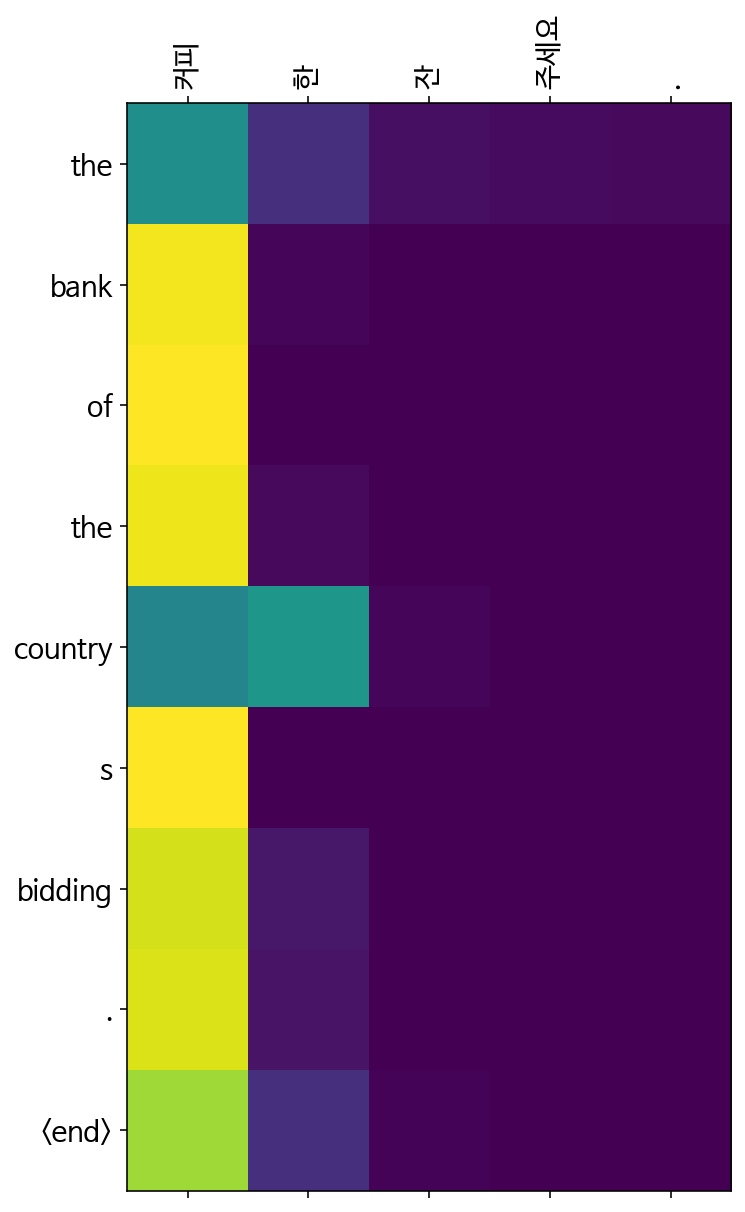

In [24]:
translate("커피 한 잔 주세요.", encoder, decoder)

Input: 너는 누구니 ?
Predicted translation: this morning <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


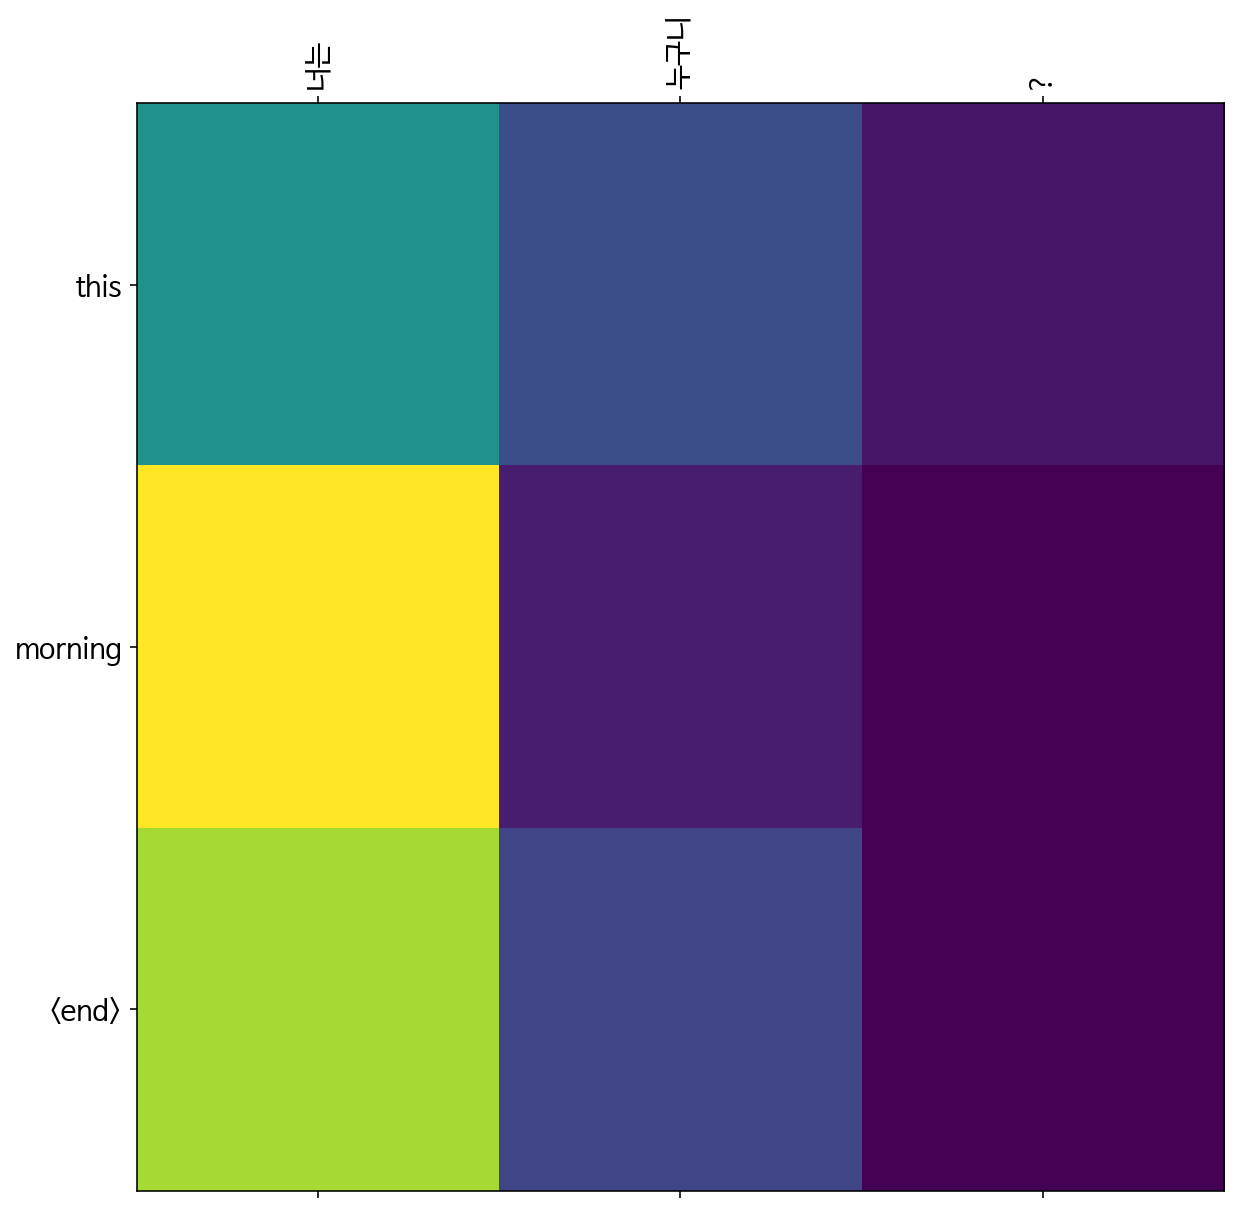

In [25]:
translate("너는 누구니?", encoder, decoder)

Input: 이들이 세상을 바꿀 수 있도록 응원합니다 .
Predicted translation: this is hilary fox spokeswoman for the film s outspoken distribution systems is deeply flawed . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


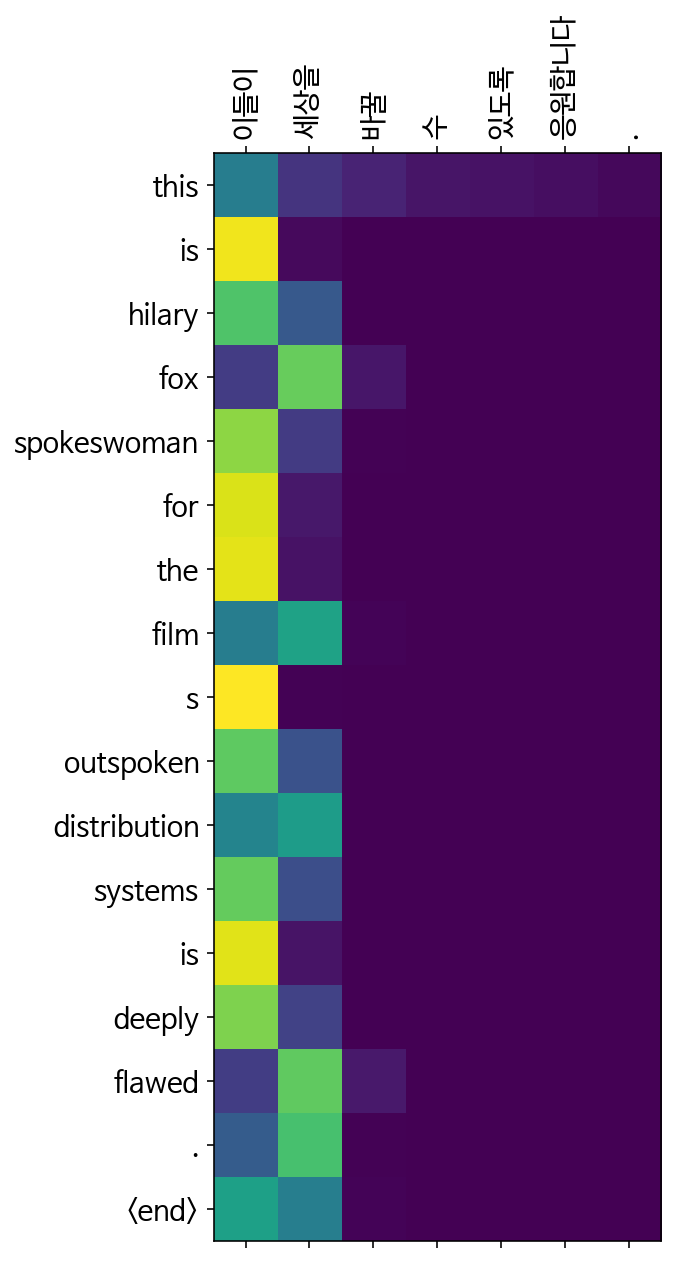

In [26]:
translate("이들이 세상을 바꿀 수 있도록 응원합니다.", encoder, decoder)

Input: 오늘 미네소타주 북부 지역은 최고 도까지 내내 오를 것으로 예상됩니다 .
Predicted translation: india has been tossed to be anemic . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


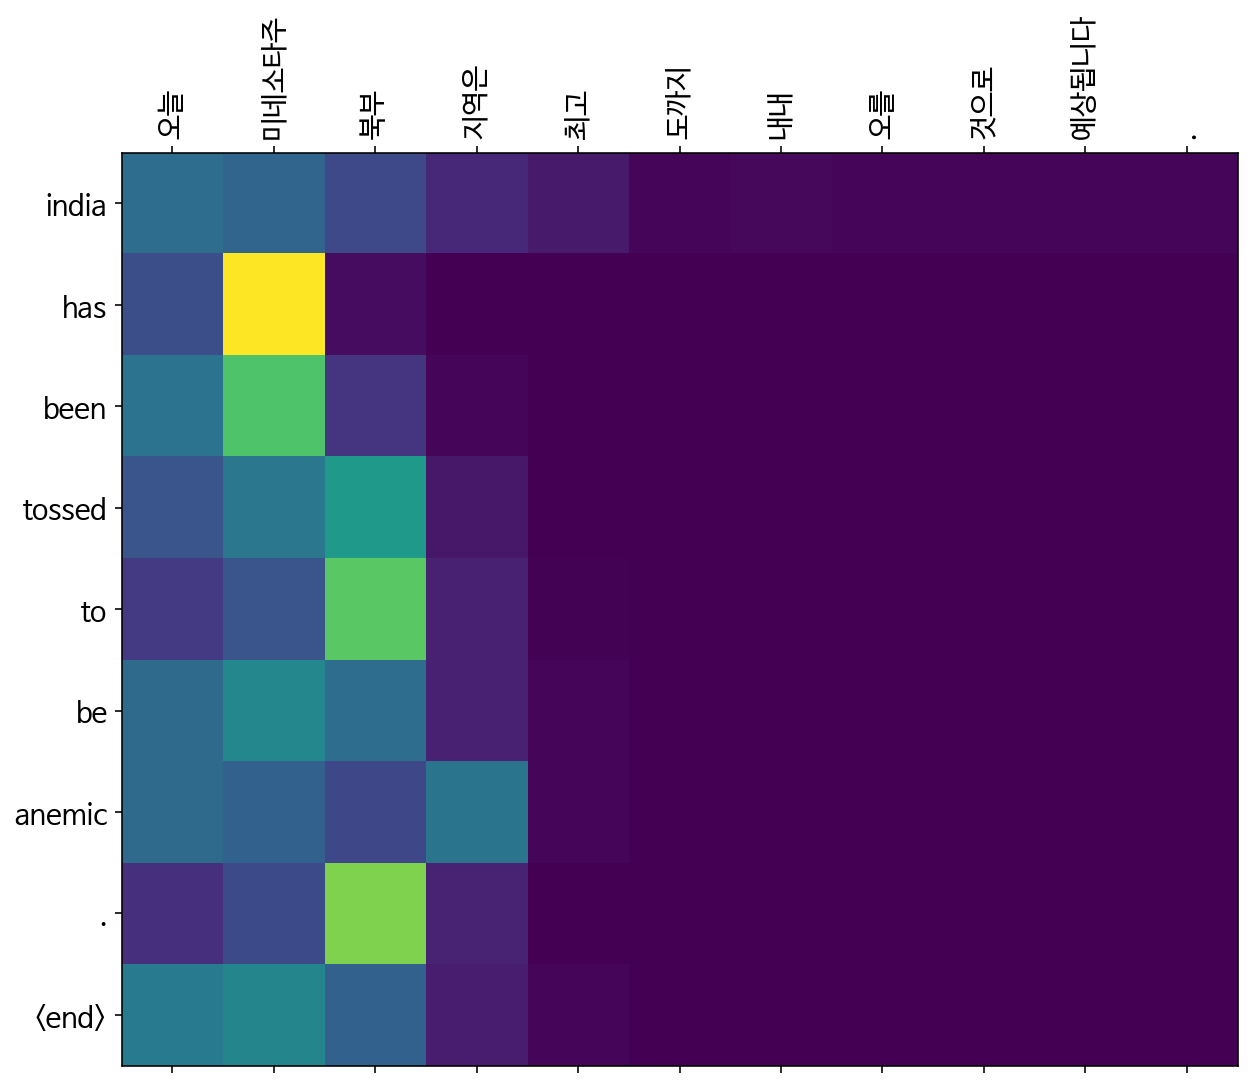

In [28]:
translate("오늘 미네소타주 북부 지역은 최고 도까지 내내 오를 것으로 예상됩니다.", encoder, decoder)

## 회고
---
번역문의 생성결과가 만족스럽게 생성되지는 않았습니다.\
loss를 줄이는 형태는 나타난 듯 싶지만, 번역문은 잘 완성되지 못 했습니다.

이번 과제에서는 모델 훈련을 조금 더 자세히 용도에 맞게 수정해보는 작업을 했던 것이 의미있게\
느껴졌습니다.\
또한 attention의 구성을 노드에서 확인 할 수 있도록 한 것이 유익했습니다.